## 1. Initialisation de Spark et chargement des données

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("spam-detection-app").getOrCreate()
data = "data/DataSet_Emails.csv"
df = spark.read.csv(data,header=True,inferSchema=True,multiLine=True,escape='"')
df.show(200)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/11 08:59:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/11 09:00:21 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///src/data/DataSet_Emails.csv


+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|_c0|message_id|                text|label|label_text|             subject|             message|      date|
+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|  0|     33214|any software just...|    1|      spam|any software just...|understanding oem...|2005-06-18|
|  1|     11929|perspective on fe...|    0|       ham|perspective on fe...|19 th , 2 : 00 pm...|2001-06-19|
|  2|     19784|wanted to try ci ...|    1|      spam|wanted to try ci ...|viagra at $ 1 . 1...|2004-09-11|
|  3|      2209|enron / hpl actua...|    0|       ham|enron / hpl actua...|teco tap 30 . 000...|2000-12-12|
|  4|     15880|looking for cheap...|    1|      spam|looking for cheap...|water past also ,...|2005-02-13|
|  5|     15726|emerging growth s...|    1|      spam|emerging growth s...|vera ,\nvcsc - br...|2005-01-18|
|  6|     21384|internet pro

## 2. Exploration du schéma et sélection des colonnes

In [2]:
df.printSchema()
df.cache()
df.count() 
df = df.select("text", "label")


root
 |-- _c0: integer (nullable = true)
 |-- message_id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- date: date (nullable = true)



25/12/11 09:00:22 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///src/data/DataSet_Emails.csv


## 3. Détection des valeurs nulles

In [3]:
from pyspark.sql import functions as f

for i in df.columns:
    count_null = df.filter(df[i].isNull()).count()
    print(f"{i} : {count_null} valeurs nulles")    

text : 51 valeurs nulles
label : 0 valeurs nulles


## 4. Suppression des valeurs nulles

In [4]:
df = df.na.drop(subset=["text"])

## 5. Comptage des emails spam et non-spam

In [5]:
count_spam_emails = df.filter(f.col("label_text")=="spam").count()
count_not_spam_email = df.filter(f.col("label_text")=="ham").count()
print(f"spam emails = {count_spam_emails}")
print(f"not spam emails = {count_not_spam_email}")

spam emails = 16112
not spam emails = 15553


## 6. Visualisation de la distribution des labels

<Axes: xlabel='label', ylabel='count'>

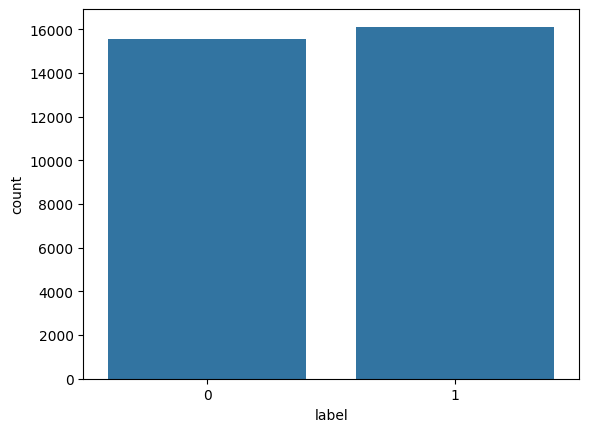

In [6]:
df1 = df.toPandas()
import pandas as pd
import matplotlib.pyplot as mpt
import seaborn as sbn

sbn.countplot(data=df1,x="label")


## 7. Préparation des données pour les nuages de mots

In [7]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string
import nltk

import matplotlib.pyplot as plt
import pandas as pd

nltk.download('stopwords')

spam_df = df.filter(f.col("label")==1)
spam_text = spam_df.select("text")
spam_list = spam_text.rdd.map(lambda row:row["text"]).collect()

not_spam_df = df.filter(f.col("label")==0)
not_spam_text = not_spam_df.select("text")
not_spam_list = not_spam_text.rdd.map(lambda row:row["text"]).collect()

spam_text_blob = " ".join(spam_list)
not_spam_text_blob = " ".join(not_spam_list)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 8. Génération du nuage de mots pour les emails spam

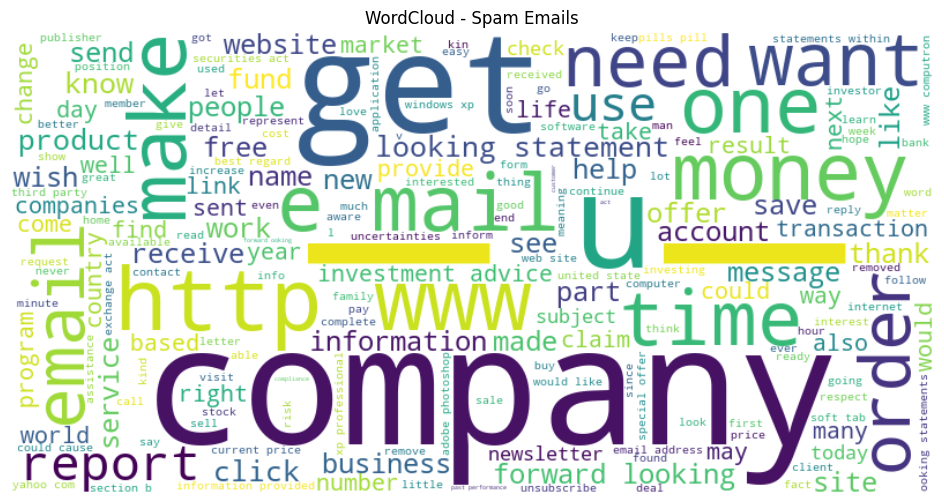

In [8]:
wordcloud_spam = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=set(stopwords.words('english'))
).generate(spam_text_blob)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Spam Emails")
plt.show()


## 9. Génération du nuage de mots pour les emails non-spam (ham)

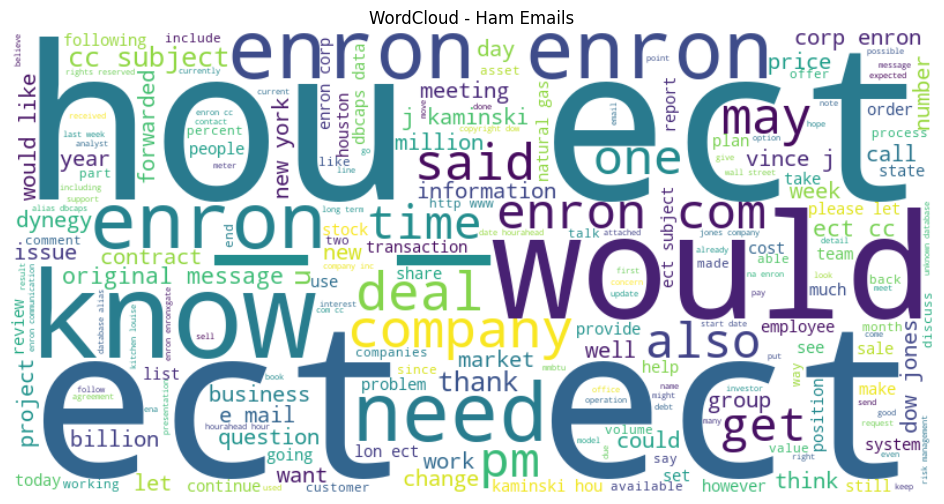

In [9]:
wordcloud_ham = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=set(stopwords.words('english'))
).generate(not_spam_text_blob)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Ham Emails")
plt.show()


## 11. Suppression des doublons et filtrage des textes vides

In [10]:
df = df.dropDuplicates()
df = df.filter(f.length(f.col("text")) > 0)

## 12. Nettoyage du texte (suppression des caractères spéciaux)

In [11]:
df_clean = df.withColumn(
    "text_clean",
    f.lower(f.regexp_replace(f.col("text"), "[^a-zA-Z0-9]", " "))
)

df_clean.show()

df_clean = df_clean.withColumn(
    "text_clean",
    f.trim(f.regexp_replace(f.col("text_clean"), "\s+", " "))
)

df_clean.show()

+--------------------+-----+--------------------+
|                text|label|          text_clean|
+--------------------+-----+--------------------+
|weekly report - 1...|    0|weekly report   1...|
|real options conf...|    0|real options conf...|
|iso share ( pnob ...|    0|iso share   pnob ...|
|organizational an...|    0|organizational an...|
|additional info d...|    0|additional info d...|
|draft doorstep bu...|    0|draft doorstep bu...|
|re : commoditylog...|    0|re   commoditylog...|
|hey ! we are givi...|    1|hey   we are givi...|
|weijun decided no...|    0|weijun decided no...|
|good day . . . . ...|    1|good day         ...|
|darker the berry ...|    1|darker the berry ...|
|your specialist '...|    1|your specialist  ...|
|re : first delive...|    0|re   first delive...|
|ews otc discussio...|    0|ews otc discussio...|
|hpl nom for july ...|    0|hpl nom for july ...|
|the results of yo...|    1|the results of yo...|
|start date : 1 / ...|    0|start date   1   ...|


+--------------------+-----+--------------------+
|                text|label|          text_clean|
+--------------------+-----+--------------------+
|weekly report - 1...|    0|weekly report 10 ...|
|real options conf...|    0|real options conf...|
|iso share ( pnob ...|    0|iso share pnob so...|
|organizational an...|    0|organizational an...|
|additional info d...|    0|additional info d...|
|draft doorstep bu...|    0|draft doorstep bu...|
|re : commoditylog...|    0|re commoditylogic...|
|hey ! we are givi...|    1|hey we are giving...|
|weijun decided no...|    0|weijun decided no...|
|good day . . . . ...|    1|good day dear fri...|
|darker the berry ...|    1|darker the berry ...|
|your specialist '...|    1|your specialist s...|
|re : first delive...|    0|re first delivery...|
|ews otc discussio...|    0|ews otc discussio...|
|hpl nom for july ...|    0|hpl nom for july ...|
|the results of yo...|    1|the results of yo...|
|start date : 1 / ...|    0|start date 1 11 0...|


## 13. Tokenisation du texte

In [12]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="text_clean", outputCol="tokens")
df_tokens = tokenizer.transform(df_clean)

df_tokens.show()

+--------------------+-----+--------------------+--------------------+
|                text|label|          text_clean|              tokens|
+--------------------+-----+--------------------+--------------------+
|weekly report - 1...|    0|weekly report 10 ...|[weekly, report, ...|
|real options conf...|    0|real options conf...|[real, options, c...|
|iso share ( pnob ...|    0|iso share pnob so...|[iso, share, pnob...|
|organizational an...|    0|organizational an...|[organizational, ...|
|additional info d...|    0|additional info d...|[additional, info...|
|draft doorstep bu...|    0|draft doorstep bu...|[draft, doorstep,...|
|re : commoditylog...|    0|re commoditylogic...|[re, commoditylog...|
|hey ! we are givi...|    1|hey we are giving...|[hey, we, are, gi...|
|weijun decided no...|    0|weijun decided no...|[weijun, decided,...|
|good day . . . . ...|    1|good day dear fri...|[good, day, dear,...|
|darker the berry ...|    1|darker the berry ...|[darker, the, ber...|
|your 

## 14. Suppression des mots vides (stop words)

In [13]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered_tokens"
)

df_filtered = remover.transform(df_tokens)

df_filtered.show()


+--------------------+-----+--------------------+--------------------+--------------------+
|                text|label|          text_clean|              tokens|     filtered_tokens|
+--------------------+-----+--------------------+--------------------+--------------------+
|weekly report - 1...|    0|weekly report 10 ...|[weekly, report, ...|[weekly, report, ...|
|real options conf...|    0|real options conf...|[real, options, c...|[real, options, c...|
|iso share ( pnob ...|    0|iso share pnob so...|[iso, share, pnob...|[iso, share, pnob...|
|organizational an...|    0|organizational an...|[organizational, ...|[organizational, ...|
|additional info d...|    0|additional info d...|[additional, info...|[additional, info...|
|draft doorstep bu...|    0|draft doorstep bu...|[draft, doorstep,...|[draft, doorstep,...|
|re : commoditylog...|    0|re commoditylogic...|[re, commoditylog...|[re, commoditylog...|
|hey ! we are givi...|    1|hey we are giving...|[hey, we, are, gi...|[hey, givi

## 15. Stemming avec PorterStemmer dans PySpark

In [14]:
from nltk.stem import PorterStemmer

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

ps = PorterStemmer()

def stem_tokens(tokens):
    result = []
    for t in tokens:
        result.append(ps.stem(t))
    return result

stem_udf = df_filtered.rdd.map(lambda row: (row["text"],row["label"],stem_tokens(row["filtered_tokens"])))
df_stemmed = stem_udf.toDF(["text","label","stemmed_tokens"])
df_stemmed.show()


+--------------------+-----+--------------------+
|                text|label|      stemmed_tokens|
+--------------------+-----+--------------------+
|weekly report - 1...|    0|[weekli, report, ...|
|real options conf...|    0|[real, option, co...|
|iso share ( pnob ...|    0|[iso, share, pnob...|
|organizational an...|    0|[organiz, announc...|
|additional info d...|    0|[addit, info, dea...|
|draft doorstep bu...|    0|[draft, doorstep,...|
|re : commoditylog...|    0|[re, commoditylog...|
|hey ! we are givi...|    1|[hey, give, away,...|
|weijun decided no...|    0|[weijun, decid, i...|
|good day . . . . ...|    1|[good, day, dear,...|
|darker the berry ...|    1|[darker, berri, s...|
|your specialist '...|    1|[specialist, appo...|
|re : first delive...|    0|[re, first, deliv...|
|ews otc discussio...|    0|[ew, otc, discuss...|
|hpl nom for july ...|    0|[hpl, nom, juli, ...|
|the results of yo...|    1|[result, applic, ...|
|start date : 1 / ...|    0|[start, date, 1, ...|


## 16. HashingTF (transforme les tokens en nombres)

In [15]:
from pyspark.ml.feature import HashingTF, IDF

hashing_tf = HashingTF(
    inputCol="stemmed_tokens",
    outputCol="rawFeatures",
    numFeatures=1000
)

df_tf = hashing_tf.transform(df_stemmed)

idf = IDF(inputCol="rawFeatures", outputCol="tfidfFeatures")
idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)


## 17. Entraînement de différents modèles de classification et analyse de leurs performances

In [16]:
train_df, test_df = df_tfidf.randomSplit([0.8, 0.2], seed=42)

In [17]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="tfidfFeatures",
    labelCol="label"
)

lr_model = lr.fit(train_df)
lr_predictions = lr_model.transform(test_df)

25/12/11 09:02:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [18]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol="tfidfFeatures",
    labelCol="label",
    numTrees=100
)

rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)


In [19]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(
    featuresCol="tfidfFeatures",
    labelCol="label",
    maxIter=50
)

gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)


## 18. Évaluation complète des modèles de classification

Model: LogisticRegression
Accuracy : 0.9476825842696629
Precision : 0.9440311725115126
Recall : 0.9500891265597148
F1 Score : 0.9476845582809901


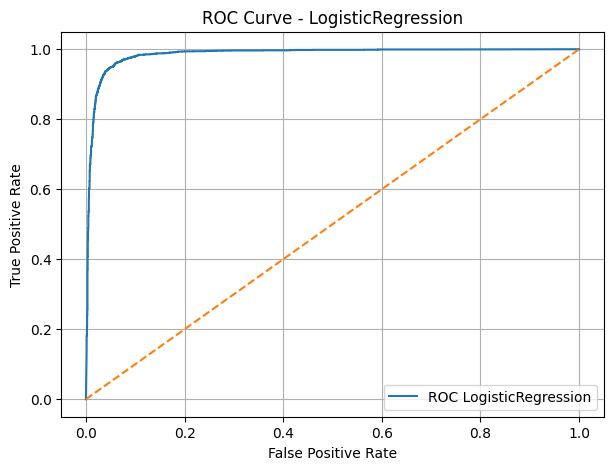

Model: RandomForest
Accuracy : 0.9120435393258427
Precision : 0.880449141347424
Recall : 0.950445632798574
F1 Score : 0.9119606679546082


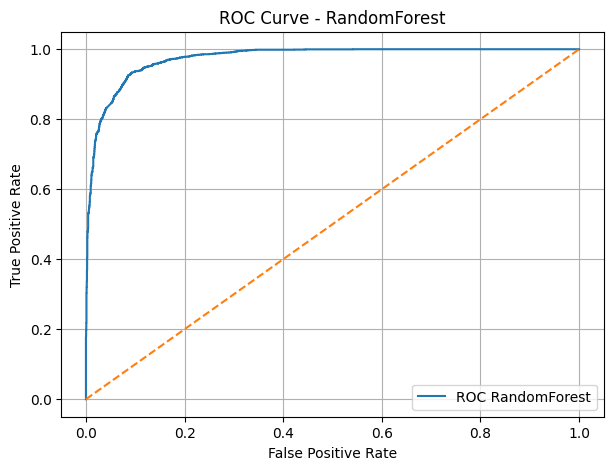

Model: GBT
Accuracy : 0.925561797752809
Precision : 0.9106588478785789
Recall : 0.9411764705882353
F1 Score : 0.925560072413123


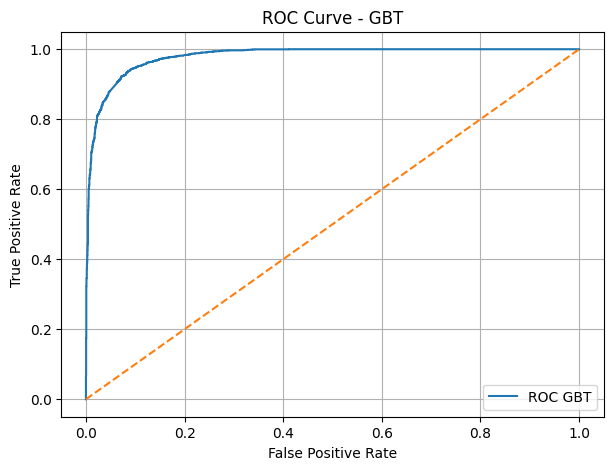

In [20]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import roc_curve, precision_recall_curve

accuracy_eval = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
precision_eval = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="precisionByLabel"
).setMetricLabel(1)
recall_eval = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="recallByLabel"
).setMetricLabel(1)
f1_eval = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

model_evaluation = [
    ("LogisticRegression", lr_predictions),
    ("RandomForest", rf_predictions),
    ("GBT", gbt_predictions)
]

for name, df in model_evaluation:
    accuracy = accuracy_eval.evaluate(df)
    precision = precision_eval.evaluate(df)
    recall = recall_eval.evaluate(df)
    f1 = f1_eval.evaluate(df)

    print("Model:", name)
    print("Accuracy :", accuracy)
    print("Precision :", precision)
    print("Recall :", recall)
    print("F1 Score :", f1)
    
    
    predictions_pd = df.select("probability", "label").toPandas()
    y_true = predictions_pd["label"].values
    y_scores = predictions_pd["probability"].apply(lambda x: x[1]).values
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
   
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f"ROC {name}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.grid()
    plt.show()

In [22]:
train_df.head()

Row(text='" content - type : text / plain ; charset = " us - ascii " ; format = flowed\ncontent - transfer - encoding : 7 bit\nsubject : [ sa ] drive everywhere\nsender : spamassassin - sightings - admin @ example . sourceforge . net\nerrors - to : spamassassin - sightings - admin @ example . sourceforge . net\nx - beenthere : spamassassin - sightings @ example . sourceforge . net\nx - mailman - version : 2 . 0 . 9 - sf . net\nprecedence : bulk\nlist - help :\nlist - post :\nlist - subscribe : ,\nlist - id :\nlist - unsubscribe : ,\nlist - archive :\nx - original - date : mon , 10 jun 2002 09 : 36 : 57 + 0900\ndate : mon , 10 jun 2002 09 : 36 : 57 + 0900\ninternational driver \' s license\nneed a new driver \' s license ?\ntoo many points or other trouble ?\nwant a license that can never be suspended\nor revoked ?\nwant an id for nightclubs or hotel check - in ?\navoid tickets , fines , and mandatory driver \' s\neducation .\nprotect your privacy , and hide your identity .\nthe united 

## 19. Pipeline Logistic Regression pour la détection de spam


In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF

# Prepare training data - use df_clean which has text_clean column
train_df_pipeline = df_clean.select("text_clean", "label")

# Build complete pipeline that starts from cleaned text
tokenizer = RegexTokenizer(inputCol="text_clean", outputCol="tokens", pattern="\\W")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="tfidfFeatures")
lr = LogisticRegression(featuresCol="tfidfFeatures", labelCol="label")

# Create and train pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])
pipeline_model = pipeline.fit(train_df_pipeline)

print("Pipeline trained successfully!")


Pipeline trained successfully!


## 20. Sauvegarder le modèle

In [26]:
save_path = "models/logistic_pipeline"

pipeline_model.write().overwrite().save(save_path)

print(f"Pipeline Logistic Regression sauvegardé dans : {save_path}")

Pipeline Logistic Regression sauvegardé dans : models/logistic_pipeline


25/12/11 09:49:15 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/spark-2927050c-6124-4a84-9577-ce16f50e61a2/pyspark-424709a3-1ade-4c6c-82f5-7df7e28c3550. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/spark-2927050c-6124-4a84-9577-ce16f50e61a2/pyspark-424709a3-1ade-4c6c-82f5-7df7e28c3550
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:199)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:116)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:94)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively(SparkFileUtils.scala:121)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively$(SparkFileUtils.scala:120)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1048)
	at org.apache.spark.util.ShutdownHookManager$.$anonfun$new$4(ShutdownHookManager.scala:70)
	at org.apache.spark.util.ShutdownHookManager$.$anonfun